In [1]:
!pip -q install inltk

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import re
import os
import sentencepiece as spm
import pickle
import pathlib
from fastai.text import *
torch.cuda.set_device(0)

working_path = '/kaggle/working'
input_data_path = '/kaggle/input'

data_paths = {}
for dirname, _, filenames in os.walk(input_data_path):
    for filename in filenames:
        data_paths[filename] = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

/kaggle/input/telugu-sentencepiece-tokenizer/__results__.html
/kaggle/input/telugu-sentencepiece-tokenizer/telugu_tok.vocab
/kaggle/input/telugu-sentencepiece-tokenizer/telugu_tok.model
/kaggle/input/telugu-sentencepiece-tokenizer/__notebook__.ipynb
/kaggle/input/telugu-sentencepiece-tokenizer/custom.css
/kaggle/input/telugu-sentencepiece-tokenizer/__output__.json
/kaggle/input/telugu-sentencepiece-tokenizer/TeluguWikiSentences.txt
/kaggle/input/telugu-language-model/__results__.html
/kaggle/input/telugu-language-model/telugu_lm.data
/kaggle/input/telugu-language-model/__notebook__.ipynb
/kaggle/input/telugu-language-model/embedding_metadata.tsv
/kaggle/input/telugu-language-model/custom.css
/kaggle/input/telugu-language-model/__output__.json
/kaggle/input/telugu-language-model/embedding_vectors.tsv
/kaggle/input/telugu-language-model/export.pkl
/kaggle/input/telugu-language-model/__results___files/__results___14_2.png
/kaggle/input/telugu-language-model/models/second.pth
/kaggle/input

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.3.0')

In [4]:
data_df = pd.read_parquet(data_paths['telugu_news_dataset.parquet'])
data_df.shape, data_df.columns

((21419, 3), Index(['title', 'text', 'category'], dtype='object'))

In [5]:
data_df['category'].value_counts()

eenadu_sports      5852
eenadu_national    5022
eenadu_business    4273
eenadu_crime       3241
eenadu_cinema      3031
Name: category, dtype: int64

In [6]:
data_df['t'] = (data_df['title'] + ' ' + data_df['text']).tolist()
data_df['t'].str.len().mean(), data_df['t'].str.len().min(), data_df['t'].str.len().max()# in characters

(1180.3481021522946, 41, 14027)

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size=0.2)
train_df.shape, test_df.shape

((17135, 4), (4284, 4))

In [8]:
sp = spm.SentencePieceProcessor()
sp.Load(data_paths['telugu_tok.model'])
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [9]:
from telugu_tokenizer_class_fastai import TeluguTokenizer
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')
tokenizer.special_cases

1.0.57


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [10]:
data_lm = TextLMDataBunch.from_df(working_path, train_df=train_df, valid_df=test_df,
                                  text_cols=["t"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_cls_lm.data')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
data_lm.show_batch()

idx,text
0,▁హెచ్చరిక లు ▁జారీ ▁చేయడం ▁గమనార్హం . ▁x x bo s ▁‘ మ సీ దు కు ▁భూ ▁కేటాయింపు ▁వద్ద ు ’ ▁ది ల్లీ : ▁అయోధ్య లో ▁మసీదు ▁కోసం ▁సున్నీ ▁వ క్ ఫ్ ▁బోర్డు కు ▁ఐ దె కర ాలు ▁కేటాయించ ాలన్న ▁ఆదేశాల ను ▁అఖిల ▁భారత ▁హిందూ ▁మహాసభ ▁సుప్రీంకోర్టు లో ▁సోమవారం ▁సవాలు ▁చేసింది . ▁మరోవైపు - ▁‘ అ యో ధ్య ’ ▁తీర్పు ను ▁సమీక్షించ ాలని ▁విన్న వ ిస్తూ ▁చరిత్రకారుడు ▁ఇర్ ఫాన్ ▁హ బీ
1,"ట్ల ▁స్పందన ▁లభించింది . ▁x x bo s ▁నీటిలో ▁యురేనియం ▁ఆ న వాళ్లు ▁ది ల్లీ : ▁దేశంలోని ▁కొన్ని ▁చోట్ల ▁లీ టరు ▁నీటిలో ▁యురేనియం ▁ఆ న వాళ్లు ▁30 ▁మైక్రో గ్రామ ులకు ▁మించి ▁ఉన్నట్లు ▁కేంద్ర ▁ జల్ ▁శక్తి ▁సహాయ మంత్రి ▁ రత న్ ▁లాల్ ▁క టా రియా ▁రాజ్యసభ లో ▁తెలిపారు . ▁ఆంధ్రప్రదేశ్ ▁ , ▁ఛత్తీస్ ▁గ డ్ ▁ , ▁గుజరాత్ ▁ , ▁హ రియా ణా , ▁హిమాచల ్ ▁ప్రదేశ్ ▁ , ▁"
2,▁తగ్గించ కుండా ▁బాద డమే ▁చేస్తున్నారు ▁బ్యాట్స్ ▁మెన్ ▁ . ▁క్రీ జు లోకి ▁వచ్చిన ▁కొత్త ▁బ్యాట్స్ ▁మన్ ▁కు దురు కు నే ▁వరకు ▁ఆ చి తూ చి ▁ఆడ ట్ లేదు . ▁తొలి ▁బంతి ▁నుంచే ▁బా దే స్తున్న ాడు . ▁కాబట్టి ▁బ్యాటింగ్ ▁కు ▁స్వర్గ ధామ ాలుగా ▁మారిన ▁బ్రి స్ టల్ ▁లాంటి ▁మైదాన ాల్లో ▁500 ▁బా దే స్తా రే మో ▁చూద్దాం . ▁అన్ని ▁జట్ల లో . . . ▁ప్రపంచ క ప్ ▁జట్ల లో ▁విధ్వంస
3,"ట్ ▁( క నీ స ▁ప్రత్యామ్నాయ ▁పన్ను ) ▁చెల్లించాల్సి న ▁పని లేదు . ▁ <unk> ▁ఈ ▁ఏడాది ▁అక్టోబరు ▁1 వ ▁తేదీ ▁నుంచి ▁మనదేశంలో ▁కొత్తగా ▁ఉత్పత్తి ▁రంగంలో ▁పెట్టుబడులు ▁పెట్టిన ▁కంపెనీలు ▁15 ▁శాతం ▁కార్పొరేట్ ▁పన్ను ▁చెల్ల ిస్తే ▁సరిపోతుంది . ▁ఇప్పటి ▁వరకు ▁ఇలాంటి వి ▁25 ▁శాతం ▁పన్ను ▁చెల్లించాల్సి ▁వచ్చేది . ▁కొత్త ▁కంపెనీ లకు ▁ఈ ▁పన్ను ▁భారం ▁బాగా ▁తగ్గింది . ▁ సెస్ ▁లు , ▁సర్ ▁ఛార్ జీ లతో ▁కలిపి ▁పన్ను ▁భారం ▁17 . 01"
4,మ్ ▁నాయకత్వంలో ▁కూడా ▁ఆడాడు . ▁‘‘ ఆ ▁ఆరోపణల ను ▁అంగీకరించ డానికి ▁నేను ▁సిద్ధంగా ▁లే ను . ▁ఒక ▁వ్యక్తిని ▁అంగీకరించ లేనంత ▁సం కు చిత ▁మనస్తత్వ ాలు ▁మా వి ▁కావు . ▁మేము ▁అలా ▁చేయ ం . ▁పాక్ ▁ప్రజల వి ▁చాలా ▁పెద్ద ▁మనసు లు . ▁మే ం ▁ప్రతి ▁ఒక్కరి నీ ▁ఆద రి స్తాం ’’ ▁అని ▁తన ▁యూ ట్యూ బ్ ▁ఛానెల్ ▁లో ▁ఇంజ మా మ్ ▁అన్నాడు . ▁పాకిస్థాన్ ▁క్రికెట్ లో ▁మతానికి ▁ఎలాంటి ▁పాత్ర ా


In [12]:
len(data_lm.vocab.itos)

25000

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.25)
learn = learn.to_fp16(clip=0.1)
# Loading the pretrained language model on telugu wikipedia
learn.load(data_paths['fourth.pth'][:-4], with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (17135 items)
x: LMTextList
▁x x bo s ▁టర్కీ కి ▁వెళితే ▁అప్రమత్త ంగా ▁ఉండ ండి ▁భారత ▁దౌత్య కార్యాలయ ం ▁హెచ్చరిక ▁ది ల్లీ : ▁టర్కీ లో ▁పర్యటించ ేందుకు ▁వెళ్లే ▁భారత ▁పర్యాటకులు ▁అప్రమత్త ంగా ▁ఉండాలని ▁భారత ▁దౌత్య కార్యాలయ ం ▁హెచ్చరిక లు ▁జారీ ▁చేసింది . ▁క శ్ మీ ర్ ▁లో ▁370 వ ▁అధికరణ ం ▁రద్దు పై ▁ఐక్యరాజ్యసమితి ▁( ఐ రా స ) లో ▁భారత్ ▁ప్రయోజనాల కు ▁భిన్నంగా ▁టర్కీ ▁మాట్లాడ ిన ▁విషయం ▁తెలిసి ందే . ▁ఈ ▁నేపథ్యంలో ▁భారత్ ▁హెచ్చరిక లు ▁జారీ ▁చేయడం ▁గమనార్హం .,▁x x bo s ▁‘ మ సీ దు కు ▁భూ ▁కేటాయింపు ▁వద్ద ు ’ ▁ది ల్లీ : ▁అయోధ్య లో ▁మసీదు ▁కోసం ▁సున్నీ ▁వ క్ ఫ్ ▁బోర్డు కు ▁ఐ దె కర ాలు ▁కేటాయించ ాలన్న ▁ఆదేశాల ను ▁అఖిల ▁భారత ▁హిందూ ▁మహాసభ ▁సుప్రీంకోర్టు లో ▁సోమవారం ▁సవాలు ▁చేసింది . ▁మరోవైపు - ▁‘ అ యో ధ్య ’ ▁తీర్పు ను ▁సమీక్షించ ాలని ▁విన్న వ ిస్తూ ▁చరిత్రకారుడు ▁ఇర్ ఫాన్ ▁హ బీ బ్ ▁ , ▁ఆర్థికవేత్త ▁ప్రభ ా త్ ▁ప ట్ నాయక్ ▁సహా ▁మొత్తం ▁40 ▁మంది ▁సంయుక్తంగా ▁సర్వ ోన్నత ▁న్యాయస్థాన ాన్ని ▁ఆశ్రయించ ారు .,▁x x bo s ▁ఆర్థిక ▁ప్రయోజనాల ▁పంపిణీ ని ▁ఆ

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


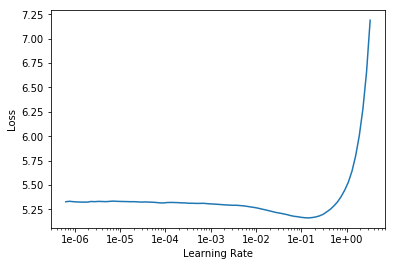

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn.save('fit_head', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,4.140157,4.070520,0.325931,02:00
1,3.902247,3.918424,0.343753,02:00


In [16]:
learn.load('fit_head', with_opt=True);

In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
learn.save('first_lm', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.722601,3.799248,0.358026,02:27
1,3.620202,3.703809,0.371852,02:27
2,3.369131,3.545822,0.391810,02:27
3,3.036781,3.439005,0.408348,02:27
4,2.754716,3.446441,0.410744,02:27


In [18]:
learn.fit_one_cycle(7, 1e-3, moms=(0.8,0.7))
learn.save('fine_tuned', with_opt=True)
learn.save_encoder('fine_tuned_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,2.691696,3.457669,0.410408,02:27
1,2.705762,3.453568,0.410787,02:27
2,2.690433,3.452214,0.411186,02:27
3,2.627461,3.462683,0.411604,02:27
4,2.572874,3.470179,0.411742,02:27
5,2.501824,3.481781,0.411582,02:27


In [19]:
del data_lm,learn

In [20]:
import gc
gc.collect()

12

In [21]:
data_clas = TextClasDataBunch.from_df(working_path, train_df=train_df, valid_df=test_df,
                                  text_cols=["t"], label_cols = ['category'], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab)

In [22]:
data_clas.show_batch()

text,target
▁x x bo s ▁మనం ▁అ జేయ ుల ం ▁ఎదురు లేని ▁టీ మ్ ▁ఇండియా ▁పాక్ ▁పై ▁కొనసాగిన ▁జై త్ర యాత్ర ▁రో హి త్ ▁సూపర్ ▁సెంచరీ ▁మాయ ▁చేసిన ▁కు ల్ ▁ దీప్ ▁4 ▁మార్చి ▁1992 . . ▁9 ▁మార్చి ▁1996 . . ▁8 ▁జూన్ ▁1999 . . ▁1 ▁మార్చి ▁2003 . . ▁30 ▁మార్చి ▁2011 . . ▁15 ▁ఫిబ్రవరి ▁2015 . . ▁భారత ▁క్రికెట్ ▁అభిమానుల ▁హృదయ ాలు ▁ఉప్ప ొ ంగ ేలా,eenadu_sports
"▁x x bo s ▁తొలి ▁దెబ్బ ▁భారత్ ▁కు ▁ఓటమి ▁రుచి ▁చూపిన ▁ఇంగ్లాండ్ ▁రో హి త్ ▁శతకం ▁వృథా ▁బె యిర్ ▁స్టో , ▁రాయ్ ▁ , ▁స్టో క్స్ ▁మెరుపు లు ▁ఆతిథ్య ▁జట్టు ▁సెమీ స్ ▁ఆశ లు ▁సజీవ ం ▁బర్మింగ్ ▁హామ్ ▁దక్షిణాఫ్రికా ▁వల్ల ▁కాలేదు . . ▁ఆస్ట్రేలియా ▁అడ్డు కో లేకపోయింది . . ▁పాకిస్థాన్ ▁ , ▁వెస్టిండీస్ ▁అసలు ▁పోటీ నే ▁ఇవ్వ లేకపోయాయి . ▁ఒక ట్ రెండు ▁మ్యాచ్ ▁ల్లో ▁ప్రతికూల ▁పరిస్థితులు ▁ఎదురైన ా ▁అధిగమించి ▁గెలుపు",eenadu_sports
"▁x x bo s ▁బంతుల ే ▁బుల్లెట్ ల యి . . ▁భారత బౌ లర్ ల ▁ధాటికి ▁వి ండీ స్ ▁వి ల వి ల ▁143 కే ▁ఆ ల ౌట్ ▁ , ▁సెమీ స్ ▁కు ▁దూరం ▁కో హ్ లీ సేన కు ▁భారీ ▁విజయం ▁నా కౌ ట్ ▁కు ▁మరింత ▁చేరువ ▁మెరి సిన ▁విరాట్ ▁ , ▁ధో ని , ▁పాండ్య ▁భారత్ ▁స్కోరు ▁26 8. ▁పసి కూ న ▁అఫ్ గాని స్థాన్ ▁తో ▁గత ▁మ్యాచ్ ▁లో",eenadu_sports
"▁x x bo s ▁సీతమ్మ ▁వర ాలు ▁ఆర్థిక ▁మంద గమనం . . ▁ప్రభుత్వ ▁ఉపశమనం . . ▁అధిక ▁సంపన్న ▁వర్గాల పై ▁సర్ ▁ఛార్ జీ ▁ఉప సం హరణ ▁వాహన ▁రంగ ానికీ ▁ఊత ం ▁బ్యాంకు లు , ▁ఎన్ ▁బీ ఎఫ్ ▁సీ లకూ ▁మద్దతు ▁అంకుర ాలకు ▁పన్ను ▁కష్టాలు ▁దూరం ▁రె పో రేటు కు ▁గృహ , ▁వాహన ▁వడ్డీ ▁రే ట్ల ▁అనుసంధానం ▁ఎం ఎస్ ▁ఎమ్ ▁ఈ లకు ▁60 ▁రోజుల్లో నే ▁జీ ఎస్ ▁టీ ▁రి ఫ ండ్",eenadu_business
"▁x x bo s ▁మనం ▁మారి పో యాం . . . ▁తెలుస ా . . !! ▁మనం ▁మారి పో యాం . . ▁తెలుస ా . . . !! ▁అవు న ండీ ▁మనం ▁మారి పో యాం . . . ▁చాలా ▁చాలా . . ▁స్ మార్ ట్ ▁ఫోన్ ▁వచ్చే సింది . . . ▁మన ▁ప్రపంచ ాన్ని ▁చిన్నది ▁చేసే సింది . ▁అమెజాన్ ▁ప్రై మ్ ▁లో నో , ▁నెట్ ▁ఫ్ల ి క్స్ ▁లో నో",eenadu_business


In [23]:
data_clas.sanity_check()

In [24]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [25]:
learn.load_encoder('fine_tuned_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (17135 items)
x: TextList
▁x x bo s ▁టర్కీ కి ▁వెళితే ▁అప్రమత్త ంగా ▁ఉండ ండి ▁భారత ▁దౌత్య కార్యాలయ ం ▁హెచ్చరిక ▁ది ల్లీ : ▁టర్కీ లో ▁పర్యటించ ేందుకు ▁వెళ్లే ▁భారత ▁పర్యాటకులు ▁అప్రమత్త ంగా ▁ఉండాలని ▁భారత ▁దౌత్య కార్యాలయ ం ▁హెచ్చరిక లు ▁జారీ ▁చేసింది . ▁క శ్ మీ ర్ ▁లో ▁370 వ ▁అధికరణ ం ▁రద్దు పై ▁ఐక్యరాజ్యసమితి ▁( ఐ రా స ) లో ▁భారత్ ▁ప్రయోజనాల కు ▁భిన్నంగా ▁టర్కీ ▁మాట్లాడ ిన ▁విషయం ▁తెలిసి ందే . ▁ఈ ▁నేపథ్యంలో ▁భారత్ ▁హెచ్చరిక లు ▁జారీ ▁చేయడం ▁గమనార్హం .,▁x x bo s ▁‘ మ సీ దు కు ▁భూ ▁కేటాయింపు ▁వద్ద ు ’ ▁ది ల్లీ : ▁అయోధ్య లో ▁మసీదు ▁కోసం ▁సున్నీ ▁వ క్ ఫ్ ▁బోర్డు కు ▁ఐ దె కర ాలు ▁కేటాయించ ాలన్న ▁ఆదేశాల ను ▁అఖిల ▁భారత ▁హిందూ ▁మహాసభ ▁సుప్రీంకోర్టు లో ▁సోమవారం ▁సవాలు ▁చేసింది . ▁మరోవైపు - ▁‘ అ యో ధ్య ’ ▁తీర్పు ను ▁సమీక్షించ ాలని ▁విన్న వ ిస్తూ ▁చరిత్రకారుడు ▁ఇర్ ఫాన్ ▁హ బీ బ్ ▁ , ▁ఆర్థికవేత్త ▁ప్రభ ా త్ ▁ప ట్ నాయక్ ▁సహా ▁మొత్తం ▁40 ▁మంది ▁సంయుక్తంగా ▁సర్వ ోన్నత ▁న్యాయస్థాన ాన్ని ▁ఆశ్రయించ ారు .,▁x x bo s ▁ఆర్థిక ▁ప్రయోజనాల ▁పంపిణీ ని ▁ఆప లే 

In [26]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


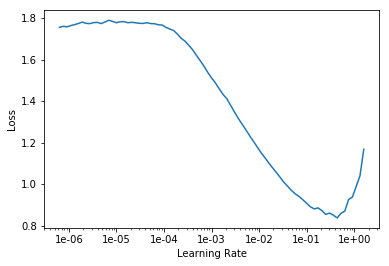

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
kappa = KappaScore()
learn.metrics = [kappa, accuracy]

In [29]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7))
learn.save('first_cls', with_opt=True)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.245896,0.160935,0.933950,0.947946,01:08
1,0.178850,0.164075,0.925792,0.941410,01:02
2,0.166497,0.132476,0.946134,0.957516,01:06
3,0.144461,0.131060,0.943747,0.955649,01:16


In [30]:
learn.load('first_cls', with_opt=True);

In [31]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.153343,0.151878,0.939874,0.952614,01:25
1,0.135946,0.129650,0.941946,0.954248,01:20
2,0.112223,0.121458,0.945542,0.957049,01:20


In [32]:
learn.save('final_cls')

In [33]:
TEXT = "వెల్లింగ్టన్‌: న్యూజిలాండ్‌తో జరిగిన నాల్గో టీ20లో టీమిండియా మరో చిరస్మరణీయమైన విజయాన్ని సాధించింది. అచ్చం మూడో టీ20ని తలపించే విధంగా సూపర్‌ ఓవర్‌కు దారి తీసిన మ్యాచ్‌లో టీమిండియా ఇంకా బంతి ఉండగానే గెలుపును అందుకుంది. సూపర్‌ ఓవర్‌లో న్యూజిలాండ్‌ 14 పరుగుల టార్గెట్‌ను నిర్దేశించగా, దాన్ని టీమిండియా సునాయాసంగా ఛేదించింది. న్యూజిలాండ్‌ సూపర్‌ ఓవర్‌ను సీఫెర్ట్‌-మున్రోలు ఆరంభించారు. కాగా, టీమిండియా ఓవర్‌ను బమ్రా అందుకున్నాడు. తొలి బంతికి సీఫెర్ట్‌ రెండు పరుగులు తీయగా, రెండో బంతికి ఫోర్‌ కొట్టాడు. మూడో బంతికి సీఫెర్ట్‌ రెండు పరుగులు తీయగా, నాల్గో బంతికి ఔటయ్యాడు. ఐదో బంతికి మున్రో ఫోర్‌ కొట్టగా, ఆరో బంతికి సింగిల్‌ తీశాడు."
learn.predict(TEXT)

(Category eenadu_sports,
 tensor(4),
 tensor([4.3957e-06, 6.9485e-05, 5.1557e-06, 1.7671e-04, 9.9974e-01]))

In [34]:
TEXT = 'ఇండోనేషియా ప్రభుత్వం బంపర్‌ ఆఫర్‌ను ప్రకటించింది. ఓ మొసలి మెడలో ఇరుక్కున్న టైర్‌ను తీసిన సాహసవంతులకు భారీ మొత్తంలో నగదు బహుమతి ఇవ్వనున్నట్లు వెల్లడించింది. అయితే ఇందుకోసం వారు 13 అడుగుల మొసలికి ఎదురు వెళ్లాల్సి ఉంటుందని పేర్కొంది. కాగా ఇండోనేషియా సెంట్రల్‌ సులవేసిలోని ఉప్పునీటి సరస్సులో నివసిస్తున్న ఈ మొసలి మెడకు మోటర్‌ సైకిల్‌ టైర్‌ ఇరుక్కుంది. రోజు రోజుకు ఆ టైరు మొసలి మెడ నుంచి పొట్టమీదకు జారుతూ బిగుసుకుపోతోంది. కాగా టైరు వల్ల ఇబ్బంది పడుతున్నమొసలి ప్రాణాలకు ప్రమాదం ఉందని గ్రహించిన అధికారులు దానిని తీయడానికి ఈ భారీ ఆఫర్‌ను ప్రకటించారు. అయితే ఆ ఆఫర్‌కు ఆకర్షితులైన కొంత మంది ఈ సాహసానికి పూనుకుని ముందుకు వచ్చారు. ఆ టైర్‌ను తీసేందుకు సరస్సులోకి దిగిన వారు మొసలిని ఎదుర్కొలేక వెనుతిరుగుతున్నారు. ఇందుకు సంబంధించిన వీడియో ప్రస్తుతం సోషల్‌ మీడియాలో వైరల్‌ అవుతుంది'
learn.predict(TEXT)

(Category eenadu_national,
 tensor(3),
 tensor([0.0182, 0.0049, 0.0155, 0.9455, 0.0159]))

In [35]:
### 